In [32]:
# Importing Packages
import codecs
import os
import re
import time
import gensim
import pandas as pd
import glob
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [10]:
# Books present
books = sorted(glob.glob("data/harrypotter/*.txt"))

print "Available Books: \n"
for i in books:
    print i.split("/")[2].split("_")[0]

Available Books: 

Book 1 - The Philosopher's Stone.txt
Book 2 - The Chamber of Secrets.txt
Book 3 - The Prisoner of Azkaban.txt
Book 4 - The Goblet of Fire.txt
Book 5 - The Order of the Phoenix.txt
Book 6 - The Half Blood Prince.txt
Book 7 - The Deathly Hallows.txt


In [11]:
# Read data from all books to single corpus variable
temp = ""
t = ""
chars = []
for book in books:
    print 
    print "Reading " + str(book).split("/")[2].split("_")[0]
    with codecs.open(book, "rb", "utf-8") as infile:
        temp += infile.read()
        chars.append(len(temp))
        print "Characters read so far " + str(len(temp))


Reading Book 1 - The Philosopher's Stone.txt
Characters read so far 474429

Reading Book 2 - The Chamber of Secrets.txt
Characters read so far 1006137

Reading Book 3 - The Prisoner of Azkaban.txt
Characters read so far 1683115

Reading Book 4 - The Goblet of Fire.txt
Characters read so far 2870365

Reading Book 5 - The Order of the Phoenix.txt
Characters read so far 4479128

Reading Book 6 - The Half Blood Prince.txt
Characters read so far 5538150

Reading Book 7 - The Deathly Hallows.txt
Characters read so far 6765174


In [12]:
lens = []
lens.append(chars[0])
for i in xrange(1, len(chars)):
    lens.append(chars[i] - chars[i-1])
lens

[474429, 531708, 676978, 1187250, 1608763, 1059022, 1227024]

<Container object of 7 artists>

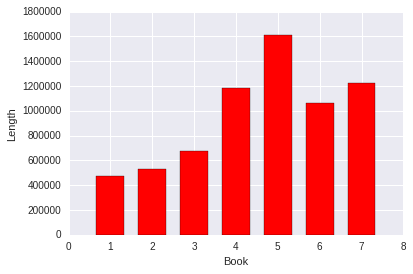

In [13]:
y = lens
N = len(y)
x = [i+1 for i in range(N)]
width = 1/1.5

pylab.xlabel("Book")
pylab.ylabel("Length")
plt.bar(x, y, width, color="red", align='center')

In [14]:
# Split into sentences
sentences = nltk.tokenize.sent_tokenize(temp)
print "Total Sentences are " + str(len(sentences))

Total Sentences are 63914


In [23]:
# sentences to list of words
sent_words = []
total_tokens = 0
for raw_sent in sentences:
    clean = nltk.word_tokenize(re.sub("[^a-zA-Z]"," ", raw_sent.strip().lower()))
    tokens = [i for i in clean if len(i) > 1]
    total_tokens += len(tokens)
    sent_words.append(tokens)

print "Total tokens are " + str(total_tokens)

Total tokens are 1103615


In [24]:
# capture collocations
bigram = gensim.models.Phrases(sent_words)
final = []
for s in sent_words:
    processed_sent = bigram[s]
    final.append(processed_sent)

In [25]:
# Sample first two sentences
final[:2]

[[u'the',
  u'boy',
  u'who_lived',
  u'mr',
  u'and',
  u'mrs_dursley',
  u'of',
  u'number_four',
  u'privet_drive',
  u'were',
  u'proud',
  u'to',
  u'say',
  u'that',
  u'they',
  u'were',
  u'perfectly',
  u'normal',
  u'thank_you',
  u'very_much'],
 [u'they',
  u'were',
  u'the',
  u'last',
  u'people',
  u'you',
  u'expect',
  u'to',
  u'be',
  u'involved',
  u'in',
  u'anything',
  u'strange',
  u'or',
  u'mysterious',
  u'because',
  u'they',
  u'just',
  u'didn',
  u'hold',
  u'with',
  u'such',
  u'nonsense']]

## Model Parameters
We are now ready to train our word embeddings over all Harry Potter books. One thing that we need to decide upon is the model parameters. We will be using gensim's word2vec model implementation for training our model.

##### Parameters
1. Window Size: 7
2. Min Count: 2
3. Dimension: 200
4. Workers: 3

To know more about the parameters [Click Here](https://radimrehurek.com/gensim/models/word2vec.html)

In [26]:
num_features = 300
min_word_count = 3
num_workers = 3
context_size = 7
seed = 1

In [27]:
model = gensim.models.Word2Vec(sent_words, window=context_size, \
                               min_count=min_word_count, workers=num_workers, \
                               seed=seed, size=num_features
                              )

In [28]:
model.train(sent_words)

4119276

In [29]:
print 'Vocabulary ' + str(len(model.wv.vocab))

Vocabulary 11735


In [30]:
if not os.path.exists("model"):
    os.makedirs("model")
model.save(os.path.join("model", "harry2vec.w2v"))

In [50]:
# words 
print 'Similar kind of words for AZKABAN: '
print [i[0] for i in model.wv.most_similar('azkaban')]
print '\n'
print 'Similar kind of words for SNAPE: '
print [i[0] for i in model.wv.most_similar('snape')]

Similar kind of words for AZKABAN: 
[u'chamber', u'goblet', u'prisoner', u'hallows', u'secrets', u'deathly', u'order', u'philosophers', u'phoenix', u'prince']


Similar kind of words for SNAPE: 
[u'dumbledore', u'slughorn', u'quirrell', u'moody', u'lupin', u'karkaroff', u'voldemort', u'sirius', u'umbridge', u'flitwick']


In [34]:
start = time.time()
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
all_word_vectors_matrix = model.wv.syn0
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)
stop = time.time() - start
print 'Time taken is ' + str(stop)

Time taken is 372.693608046


In [51]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[model.vocab[word].index])
            for word in model.vocab
        ]
    ],
    columns=["word", "x", "y"]
)
points.head(20)

,word,x,y
0,raining,-0.815268,-2.405247
1,yellow,3.388919,2.934252
2,four,2.455602,3.883873
3,rocketing,-0.084980,-5.673094
4,woods,-3.480195,-2.075241
5,spiders,4.297810,0.316103
6,ornate,-1.020054,1.384538
7,conjuring,-0.355317,-3.486272
8,aggression,0.735922,-4.838119
9,marching,-3.540225,-2.435823


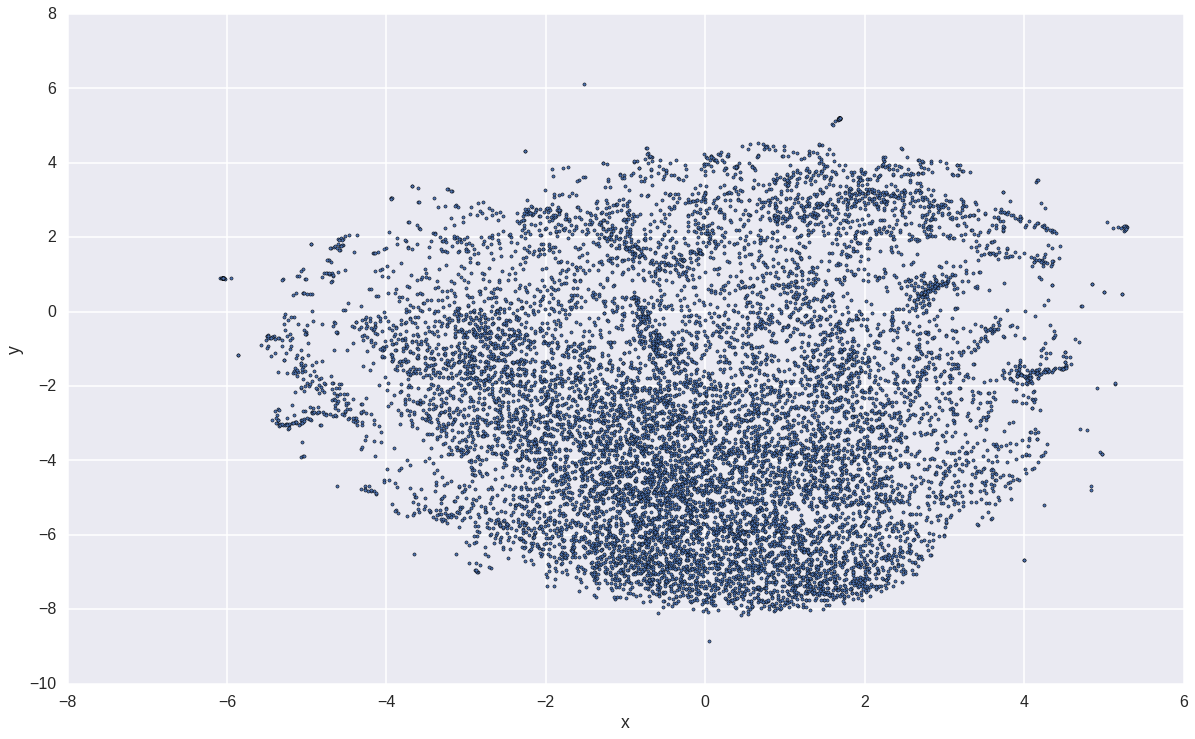

In [52]:
sns.set_context("poster")
points.plot.scatter("x", "y", s=10, figsize=(20, 12))